# Cubic spline distribution

In [1]:
import torch
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def cubic(t, deriv=0):
    if deriv == -1:
        return torch.tensor([t, t**2/2, t**3/3, t**4/4])
    if deriv == 0:
        return torch.tensor([1., t, t**2, t**3])
    if deriv == 1:
        return torch.tensor([0., 1., 2 * t, 3*t**2])
    if deriv == 2:
        return torch.tensor([0., 0., 2., 6*t])

In [3]:
vec = []
mat = []

def constrain(value, f=torch.zeros(4), g=torch.zeros(4)):
    vec.append(value)
    mat.append(torch.cat([f, g]))

constrain(0., f=cubic(0))
constrain(0., f=cubic(0, deriv=1))
constrain(0., f=cubic(0, deriv=2))
constrain(0., f=cubic(1), g=-cubic(1))
constrain(0., f=cubic(1, deriv=1), g=cubic(1, deriv=1))
constrain(0., f=cubic(1, deriv=2), g=-cubic(1, deriv=2))
constrain(0., g=cubic(0, deriv=1))
constrain(.5, f=cubic(1, deriv=-1), g=cubic(1, deriv=-1))

vec = torch.tensor(vec)
mat = torch.stack(mat)
print(mat)
coef = torch.solve(vec.unsqueeze(-1), mat)[0]

f_coef = coef[:4, 0]
g_coef = coef[4:, 0]
print(f_coef)
print(g_coef)

tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  2.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.0000,  1.0000,  1.0000,  1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
        [ 0.0000,  1.0000,  2.0000,  3.0000,  0.0000,  1.0000,  2.0000,  3.0000],
        [ 0.0000,  0.0000,  2.0000,  6.0000, -0.0000, -0.0000, -2.0000, -6.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [ 1.0000,  0.5000,  0.3333,  0.2500,  1.0000,  0.5000,  0.3333,  0.2500]])
tensor([0.0000, 0.0000, 0.0000, 0.1667])
tensor([ 6.6667e-01, -1.1921e-07, -1.0000e+00,  5.0000e-01])


In [4]:
def f(t):
    return t.unsqueeze(-1).pow(torch.arange(4.)).mul(f_coef).sum(-1)
def g(t):
    return t.unsqueeze(-1).pow(torch.arange(4.)).mul(g_coef).sum(-1)

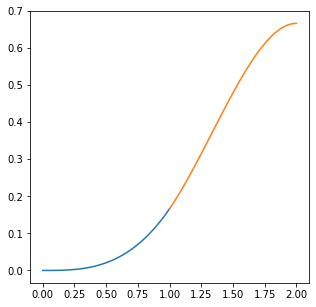

In [5]:
plt.figure(figsize=(5, 5)).patch.set_color("white")
t = torch.linspace(0., 1., 100)
plt.plot(t, f(t))
plt.plot(2 - t, g(t))

In [6]:
print(f_coef * 6)
print(g_coef * 6)

tensor([0.0000, 0.0000, 0.0000, 1.0000])
tensor([ 4.0000e+00, -7.1526e-07, -6.0000e+00,  3.0000e+00])


Now testing the final implementation:

In [7]:
def quantize(x_real):
    lb = x_real.detach().floor()
    s = x_real - lb
    ss = s * s
    t = 1 - s
    tt = t * t
    probs = torch.stack([
        s * ss,
        4 + tt * (3 * t - 6),
        4 + ss * (3 * s - 6),
        t * tt,
    ], dim=-1) / 6
    return probs

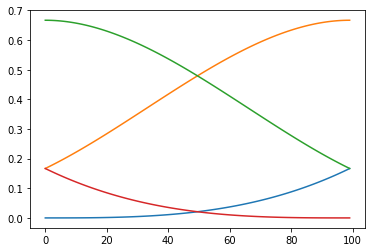

In [8]:
plt.plot(quantize(t * 0.9999));

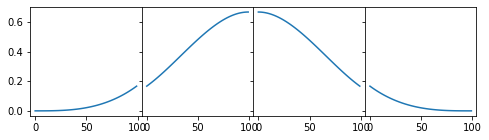

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(8, 2), sharey=True)
for part, ax in zip(quantize(t * 0.9999).T, axes):
    ax.plot(part)
plt.subplots_adjust(wspace=0)